In [26]:
library(dplyr)
library(tidyr)
library(ggplot2)

In [85]:
# Load and install required packages
for (pkg in c("quantmod", "xts")) {
  if (!requireNamespace(pkg, quietly = TRUE)) {
    install.packages(pkg)
  }
  require(pkg, character.only = TRUE)
}

# Metadata
symbols <- data.frame(
  name = c(
    "TSX_Composite", "Canada_Financials_Index", "Canada_Energy_Index",
    "Canada_Materials_Index", "Canada_Information_Technology_Index",
    "Canada_Utilities_Index", "Canada_Consumer_Staples_Index",
    "Canada_Real_Estate_Index", "Canada_Health_Care_Index",
    "Canada_Consumer_Discretionary_Index", "Canada_Corporate_Bonds",
    "Canada_Government_Bonds", "US_oil_gas", "Global_Materials",
    "US_Government_Bonds", "US_Real_Estate", "SP_500"
  ),
  etf_ticker = c(
    "XIC.TO", "XFN.TO", "XEG.TO", "XMA.TO", "XIT.TO", "XUT.TO",
    "XST.TO", "XRE.TO", "XHC.TO", "XMD.TO", "XCB.TO", "XGB.TO",
    "IEO", "MXI", "GOVT", "VNQ", "SPY"
  ),
  stringsAsFactors = FALSE
)

# Set date range
start <- as.Date("2019-01-01")
end <- Sys.Date()  # Use current date for latest data

tickers <- symbols$etf_ticker
nice_names <- symbols$name

# Download daily data with error handling
stock_data <- list()
for (tk in tickers) {
  tryCatch({
    data <- getSymbols(tk, src = "yahoo", from = start, to = end, auto.assign = FALSE)
    # Clean timestamps to avoid fractional seconds
    index(data) <- as.Date(index(data))  # Convert to date-only
    stock_data[[tk]] <- data
  }, error = function(e) {
    message(sprintf("Failed to download data for %s: %s", tk, e$message))
  })
}

# Check if any data was downloaded
if (length(stock_data) == 0) stop("No data downloaded successfully.")

# Extract and combine Close prices from stock_data
close_data <- do.call(cbind, lapply(names(stock_data), function(tk) {
  x <- stock_data[[tk]]
  if (is.null(x) || !is.xts(x) || nrow(x) == 0) {
    message(sprintf("Skipping %s: Invalid or empty data.", tk))
    return(NULL)
  }
  # Find Close column (case-insensitive, handles variations like Adjusted.Close)
  close_col <- grep("Close", colnames(x), value = TRUE, ignore.case = TRUE)
  if (length(close_col) == 0) {
    message(sprintf("Skipping %s: No Close column found.", tk))
    return(NULL)
  }
  # Use the first matching Close column (e.g., prefer Adjusted.Close if available)
  close_col <- close_col[1]
  # Rename to ticker symbol
  colnames(x)[colnames(x) == close_col] <- tk
  return(x[, tk])
}))

# Remove NULL entries and check if any valid data remains
close_data <- close_data[, !sapply(close_data, is.null)]
if (ncol(close_data) == 0) stop("No valid Close data extracted.")

# Rename columns to friendly names
colnames(close_data) <- symbols$name[match(colnames(close_data), symbols$etf_ticker)]

# Filter to keep only the last day of each week
weekly_endpoints <- endpoints(close_data, on = "weeks", k = 1)
close_data <- close_data[weekly_endpoints, ]

# Verify that data remains after filtering
if (nrow(close_data) == 0) stop("No data remains after filtering to weekly endpoints.")

close_data <- data.frame(close_data)

pct_change <- close_data %>%
  # keep if you have a date column to ensure order
  arrange(dplyr::across(any_of(c("date","Date","DATE")), .names = NULL)) %>%
  mutate(across(where(is.numeric), ~ .x / lag(.x) - 1))

close_data$TSX_lagged <- dplyr::lag(close_data$TSX_Composite, n = 1)

In [86]:
head(close_data)

,TSX_Composite,Canada_Financials_Index,Canada_Energy_Index,Canada_Materials_Index,Canada_Information_Technology_Index,Canada_Utilities_Index,Canada_Consumer_Staples_Index,Canada_Real_Estate_Index,Canada_Health_Care_Index,Canada_Consumer_Discretionary_Index,Canada_Corporate_Bonds,Canada_Government_Bonds,US_oil_gas,Global_Materials,US_Government_Bonds,US_Real_Estate,SP_500,TSX_lagged
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-01-04,23.24215,34.08,9.22,11.95,19.83366,20.60020,29.26012,16.88259,46.39090,22.17,20.70,21.35,54.75,58.31,24.86,74.32,252.39,NA
2019-01-11,24.06282,35.09,9.54,12.02,21.15514,21.20041,30.47428,17.68219,47.24923,23.18,20.71,21.33,57.38,59.60,24.79,77.75,258.98,23.24215
2019-01-18,24.67072,36.25,9.78,11.99,21.78171,21.59715,30.60511,17.80364,48.20062,23.51,20.73,21.23,59.28,60.93,24.69,79.43,266.46,24.06282
2019-01-25,24.75177,36.17,9.48,12.35,22.10069,21.74975,30.33821,18.05668,47.62151,23.73,20.82,21.27,57.87,60.87,24.76,80.46,265.78,24.67072
2019-02-01,25.03546,36.47,9.44,12.83,22.41966,21.81078,30.44811,18.16802,48.53154,24.15,20.92,21.35,58.74,62.03,24.79,82.88,270.06,24.75177
2019-02-08,25.22796,36.84,9.23,12.96,22.95509,22.28891,31.48956,18.54251,48.27301,24.43,20.96,21.46,55.58,60.65,24.88,84.12,270.47,25.03546


In [87]:
cutoff <- as.Date('2024-01-01')
idx <- as.Date(rownames(close_data))
train <- close_data[idx <  cutoff, , drop = FALSE]
test  <- close_data[idx >= cutoff, , drop = FALSE]
x_reg_cols <- setdiff(colnames(train), "TSX_Composite")
y_train <- train$TSX_Composite
y_test  <- test$TSX_Composite
xreg_train <- train[, x_reg_cols, drop = FALSE]
xreg_test  <- test[, x_reg_cols, drop = FALSE]
n_steps <- 5
n_states <- 2

In [100]:
## Naive model
hid_model <- hmmTMB::MarkovChain$new(
  data = train,
  n_states = n_states
)
obs_model <- hmmTMB::Observation$new(
    data = train,
    n_states = n_states,
    dists = list(TSX_Composite = "norm"),
    par = list(TSX_Composite = list(mean = c(0, 1), sd = c(1, 1))),
    formula = list(TSX_Composite = list( mean =  ~TSX_lagged))
  )
obs_model$update_par(par = obs_model$suggest_initial())
hmm <- hmmTMB::HMM$new(hid = hid_model, obs = obs_model)
hmm$fit(silent = TRUE)
fc <- hmmTMB::Forecast$new(
  hmm = hmm,
  forecast_data = test[0:n_steps, ]
)


Replacing NAs in covariates by last non-NA values.

Warning message:
“Using 100 evaluation points in range ±10% of training data for observation variable 'TSX_Composite'. Setting eval_range explicitly is recommended.”


In [101]:
obs_model$coeff_fe()

TSX_Composite.mean.state1.(Intercept),6.7084805
TSX_Composite.mean.state1.TSX_lagged,0.7325519
TSX_Composite.mean.state2.(Intercept),0.7432756
TSX_Composite.mean.state2.TSX_lagged,0.9762436
TSX_Composite.sd.state1.(Intercept),-0.5398367
TSX_Composite.sd.state2.(Intercept),-0.4358753


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


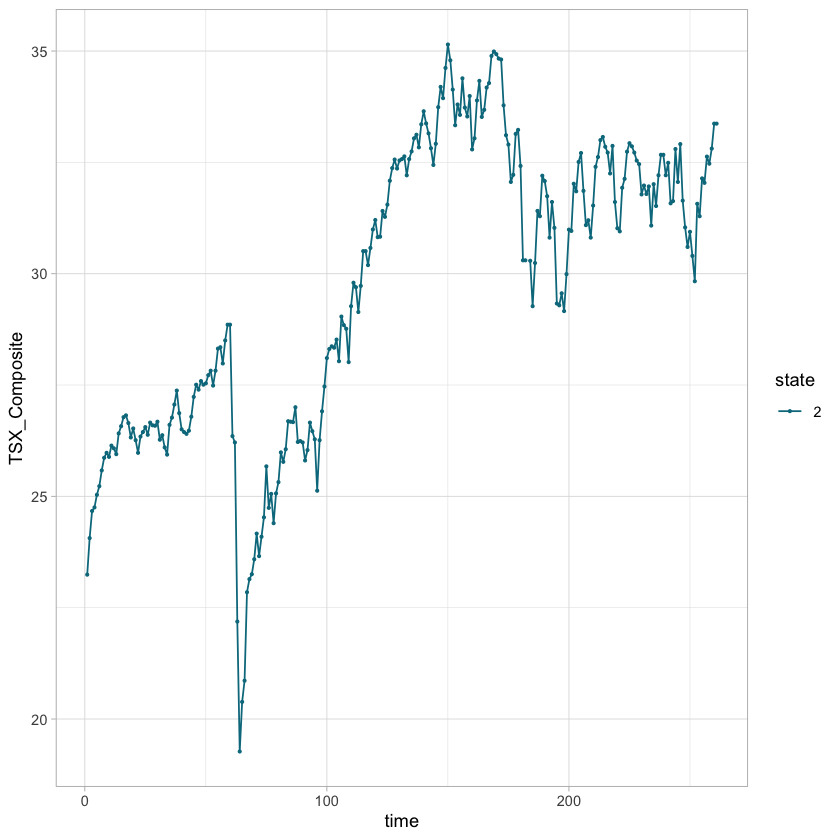

In [107]:
hmm$plot_ts("TSX_Composite") + geom_point(size=0.5)

In [ ]:
step_size <- diff(fc$eval_range()[[1]])[1]
mean <- t(as.matrix(fc$eval_range()[[1]])) %*% fc$forecast_dists()[[1]] * step_size
cdf <- apply(fc$forecast_dists()[[1]], 2, function(x) cumsum(x) / sum(x))
lower_bound <- apply(cdf, 2, function(col) fc$eval_range()[[1]][which.min(abs(col - 0.16))])
upper_bound <- apply(cdf, 2, function(col) fc$eval_range()[[1]][which.min(abs(col - 0.84))])


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


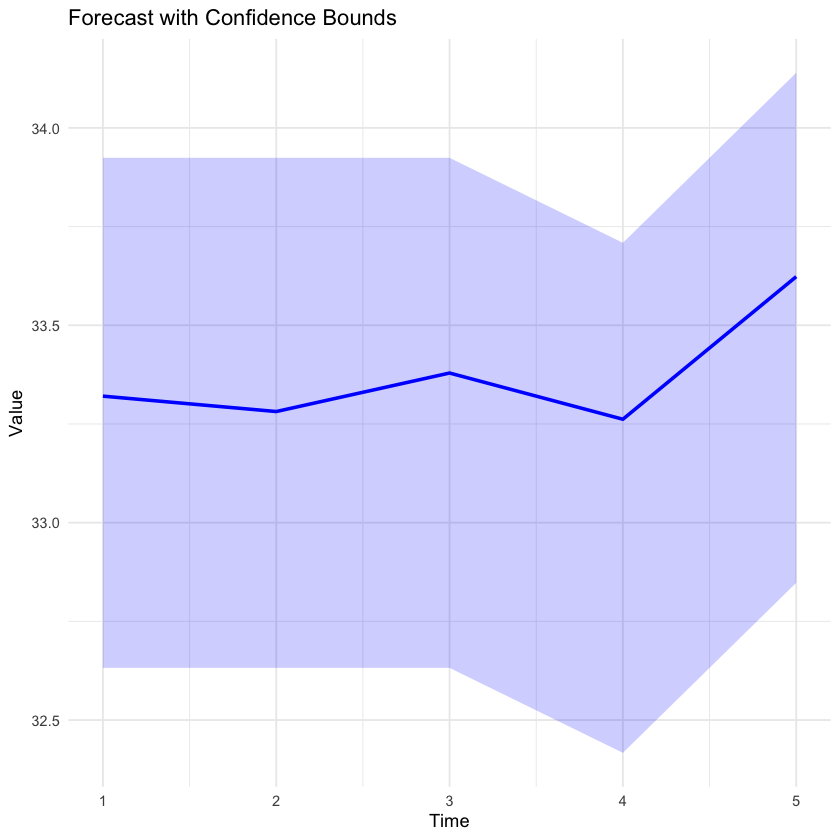

In [147]:
library(ggplot2)

# Create a data frame for plotting
forecast_df <- data.frame(
  Time = seq_len(length(mean)),
  Mean = as.vector(mean),
  Lower = lower_bound,
  Upper = upper_bound
)

# Plot the mean with shaded bounds
ggplot(forecast_df, aes(x = Time)) +
  geom_line(aes(y = Mean), color = "blue", size = 1) +
  geom_ribbon(aes(ymin = Lower, ymax = Upper), fill = "blue", alpha = 0.2) +
  labs(title = "Forecast with Confidence Bounds", x = "Time", y = "Value") +
  theme_minimal()

In [148]:
fc$hidden_state_forecast()

4.158418e-08,4.177688e-08,4.177777e-08,4.177778e-08,4.177778e-08
1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [161]:
fc$obs_par_forecast()[, , 2]

,state 1,state 2
TSX_Composite.mean,31.1244381,33.2814762
TSX_Composite.sd,0.5828434,0.6466984


In [160]:
mean

33.32052,33.28148,33.3791,33.26195,33.62316


In [162]:
train

,TSX_Composite,Canada_Financials_Index,Canada_Energy_Index,Canada_Materials_Index,Canada_Information_Technology_Index,Canada_Utilities_Index,Canada_Consumer_Staples_Index,Canada_Real_Estate_Index,Canada_Health_Care_Index,Canada_Consumer_Discretionary_Index,Canada_Corporate_Bonds,Canada_Government_Bonds,US_oil_gas,Global_Materials,US_Government_Bonds,US_Real_Estate,SP_500,TSX_lagged
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-01-04,23.24215,34.08,9.22,11.95,19.83366,20.60020,29.26012,16.88259,46.39090,22.17,20.70,21.35,54.75,58.31,24.86,74.32,252.39,NA
2019-01-11,24.06282,35.09,9.54,12.02,21.15514,21.20041,30.47428,17.68219,47.24923,23.18,20.71,21.33,57.38,59.60,24.79,77.75,258.98,23.24215
2019-01-18,24.67072,36.25,9.78,11.99,21.78171,21.59715,30.60511,17.80364,48.20062,23.51,20.73,21.23,59.28,60.93,24.69,79.43,266.46,24.06282
2019-01-25,24.75177,36.17,9.48,12.35,22.10069,21.74975,30.33821,18.05668,47.62151,23.73,20.82,21.27,57.87,60.87,24.76,80.46,265.78,24.67072
2019-02-01,25.03546,36.47,9.44,12.83,22.41966,21.81078,30.44811,18.16802,48.53154,24.15,20.92,21.35,58.74,62.03,24.79,82.88,270.06,24.75177
2019-02-08,25.22796,36.84,9.23,12.96,22.95509,22.28891,31.48956,18.54251,48.27301,24.43,20.96,21.46,55.58,60.65,24.88,84.12,270.47,25.03546
2019-02-15,25.58257,37.26,9.92,12.88,23.69558,22.25839,31.42153,18.52227,49.80352,24.76,21.01,21.51,59.51,62.53,24.86,85.09,277.37,25.22796
2019-02-22,25.86626,37.54,9.98,13.21,24.21962,22.23805,31.31162,18.55263,49.58635,25.11,20.96,21.49,58.52,63.92,24.87,85.12,279.14,25.58257
2019-03-01,25.97771,37.63,10.16,12.83,24.58417,22.74669,31.58900,18.74494,50.06205,25.21,20.97,21.41,58.35,63.32,24.68,83.73,280.42,25.86626
